In [1]:
import sys
import math

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets

from models.utils.random_features import RandomFeatureGaussianProcess
from models.resnet_sngp import train_one_epoch
from models.utils.spectral_normalization import spectral_norm_linear

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


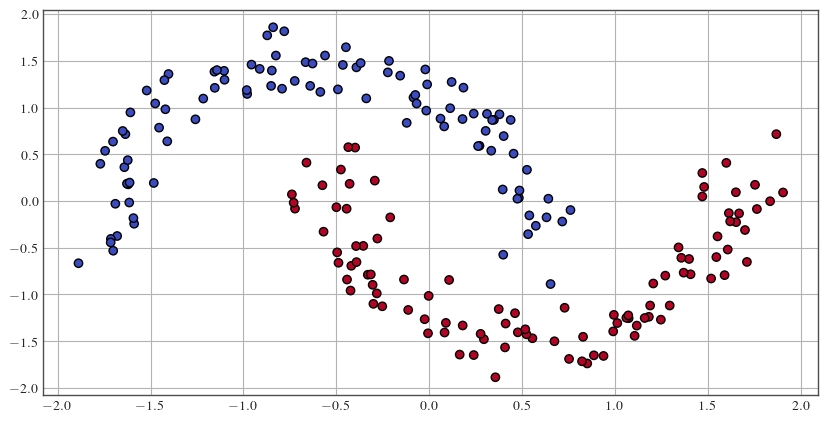

In [4]:
X, y = datasets.make_moons(200, noise=.1)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [5]:
class SNGPNet(nn.Module):
    def __init__(self,
                 num_classes: int,
                 use_spectral_norm: bool = True,
                 spectral_norm_params: dict = {},
                 gp_params: dict = {},
                 n_residual_layers: int = 6,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        def linear_layer(*args, **kwargs):
            if use_spectral_norm:
                return spectral_norm_linear(nn.Linear(*args, **kwargs), **spectral_norm_params)
            else:
                return nn.Linear(*args, **kwargs)

        self.first = nn.Linear(2, feature_dim)
        self.residuals = nn.ModuleList([linear_layer(128, 128) for _ in range(n_residual_layers)])
        self.last = RandomFeatureGaussianProcess(
            in_features=feature_dim,
            out_features=num_classes,
            **gp_params,
        )
        self.act = nn.ReLU()

    def reset_precision_matrix(self):
        self.last.reset_precision_matrix()

    def forward(self, x, mean_field=False, return_cov=False):
        # : Added activation to first layer
        x = self.act(self.first(x))
        for residual in self.residuals:
            x = self.act(residual(x) + x)

        if mean_field:
            out = self.last.forward_mean_field(x)
        else:
            out = self.last(x, return_cov=return_cov)

        return out


In [6]:
@torch.no_grad()
def plot_contour(model, X, y, ax=None):
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz, mean_field=True)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

Epoch [0] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.8654 (0.8654) acc1: 35.9375 (35.9375) time: 0.3190 data: 0.0009 max mem: 15
Epoch [0] Total time: 0:00:00
Epoch [1] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.1895 (0.1895) acc1: 92.9688 (92.9688) time: 0.0057 data: 0.0009 max mem: 16
Epoch [1] Total time: 0:00:00
Epoch [2] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.1228 (0.1228) acc1: 96.8750 (96.8750) time: 0.0059 data: 0.0008 max mem: 16
Epoch [2] Total time: 0:00:00
Epoch [3] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0700 (0.0700) acc1: 99.2188 (99.2188) time: 0.0048 data: 0.0006 max mem: 16
Epoch [3] Total time: 0:00:00
Epoch [4] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0308 (0.0308) acc1: 100.0000 (100.0000) time: 0.0063 data: 0.0010 max mem: 16
Epoch [4] Total time: 0:00:00
Epoch [5] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0194 (0.0194) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0006 max mem: 16
Epoch [5] Total time: 0:00:00
Epoch [6] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0114 (0.0114) acc1: 100.0000 (100.0000

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


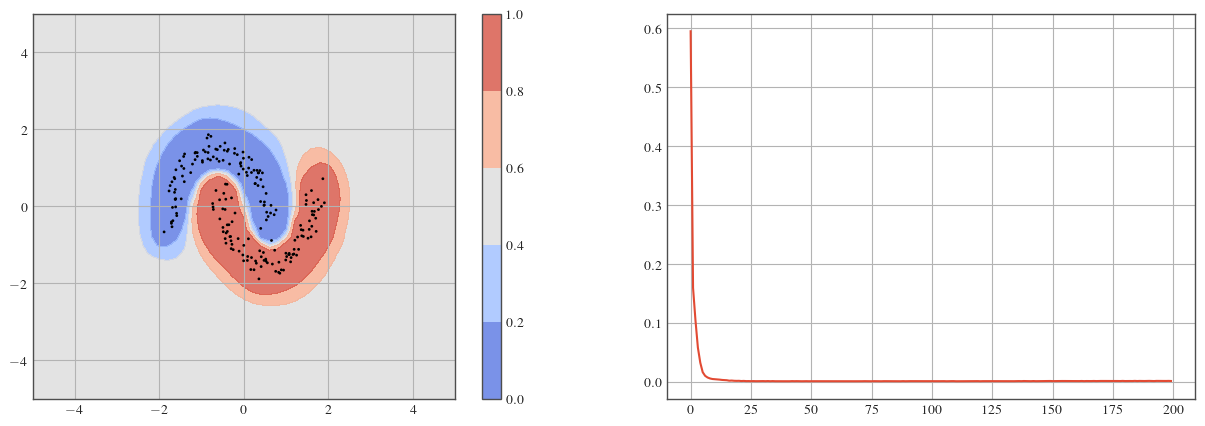

In [7]:
spectral_norm_params = dict(
    norm_bound=.9,
    n_power_iterations=1
)
gp_params = dict(
    num_inducing=1024,
    kernel_scale=.1,
    normalize_input=False,
    random_feature_type='orf',
    scale_random_features=False,
    # mean_field_factor=.1,
    # cov_momentum=-1,
    # ridge_penalty=1
)
optimizer_params = dict(
    lr=1e-2,
    weight_decay=1e-2,
    momentum=.9,
)
epochs = 200

torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = SNGPNet(num_classes=2, use_spectral_norm=True, spectral_norm_params=spectral_norm_params, gp_params=gp_params)

optimizer = torch.optim.SGD(model.parameters(), **optimizer_params)
criterion = nn.CrossEntropyLoss()
history = []
for i in range(epochs):
    train_stats = train_one_epoch(model, train_loader, criterion, optimizer, device='cuda', epoch=i)
    history.append(train_stats)

model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plot_contour(model, X, y, ax=plt.subplot(121))
plt.show()